In [1]:
!pip install tensorflow


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [3]:

skin_df = pd.read_csv('/content/drive/MyDrive/HAM1000/HAM10000_metadata.csv')

In [4]:
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


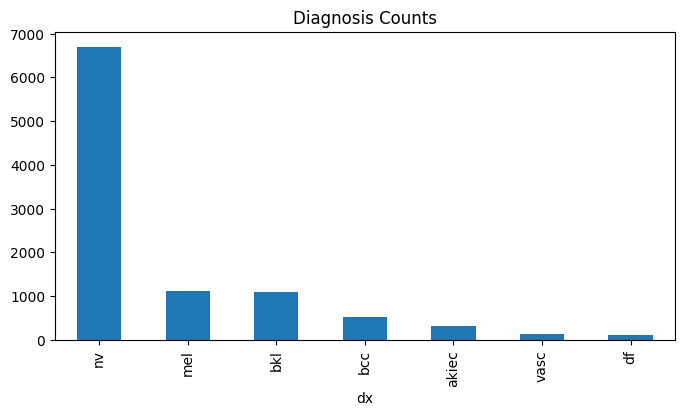

In [5]:
skin_df['dx'].value_counts().plot(kind='bar', figsize=(8, 4), title='Diagnosis Counts')
plt.show()


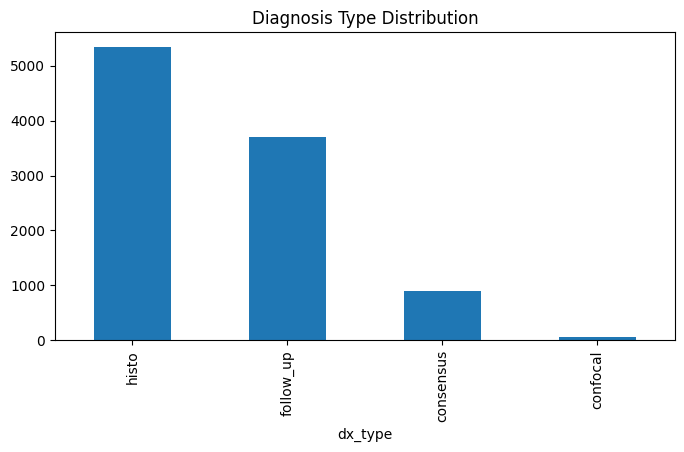

In [6]:
skin_df['dx_type'].value_counts().plot(kind='bar', figsize=(8, 4), title='Diagnosis Type Distribution')
plt.show()



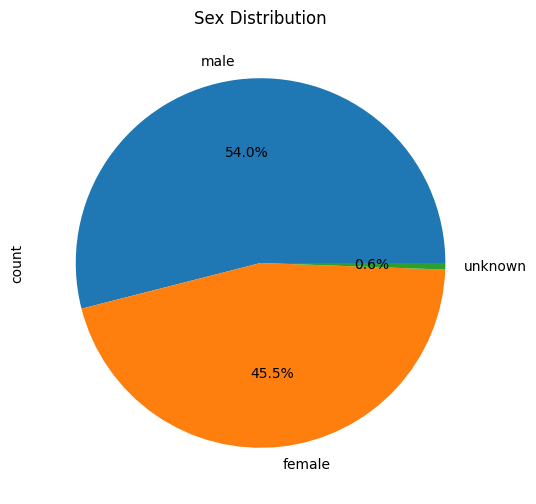

In [7]:
skin_df['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title='Sex Distribution')
plt.show()


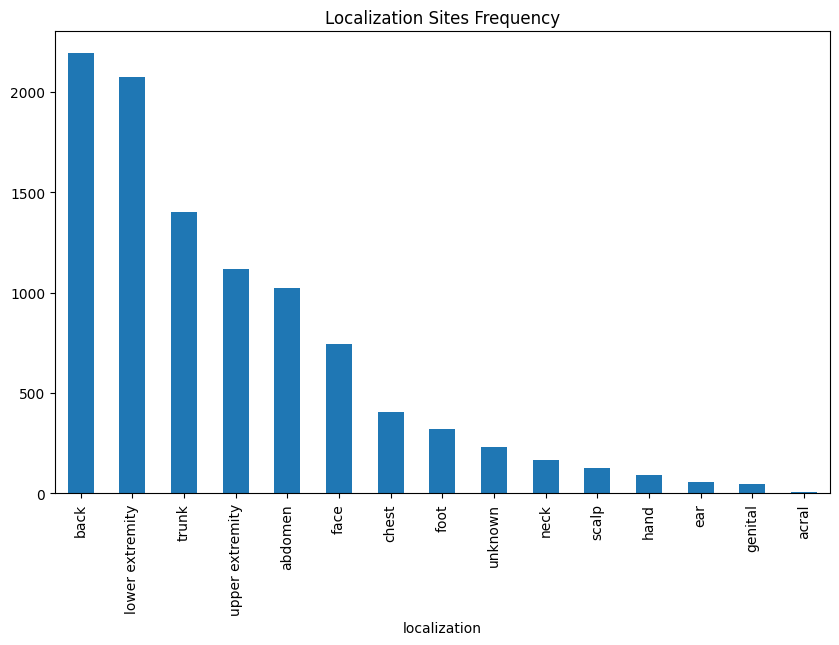

In [8]:
skin_df['localization'].value_counts().plot(kind='bar', figsize=(10, 6), title='Localization Sites Frequency')
plt.show()


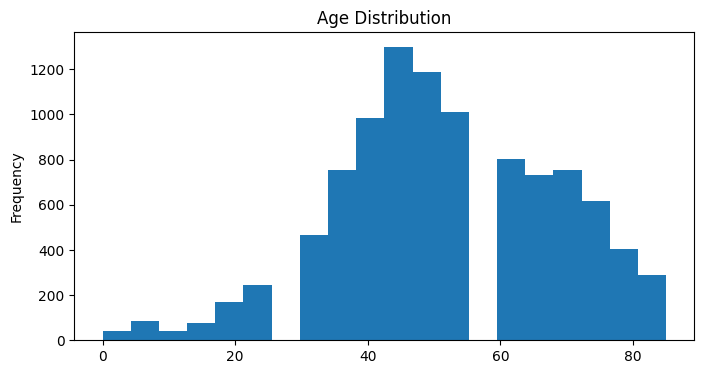

In [9]:
skin_df['age'].dropna().plot(kind='hist', bins=20, title='Age Distribution', figsize=(8, 4))
plt.show()


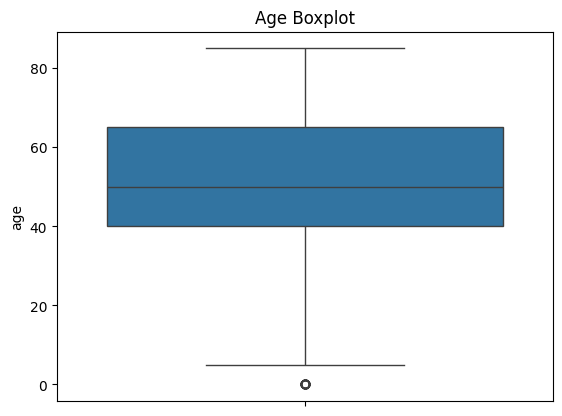

In [10]:
sns.boxplot(y=skin_df['age'])
plt.title('Age Boxplot')
plt.show()


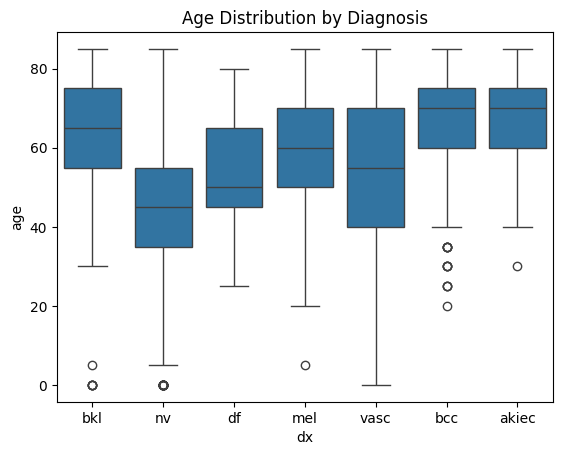

In [11]:
sns.boxplot(x='dx', y='age', data=skin_df)
plt.title('Age Distribution by Diagnosis')
plt.show()


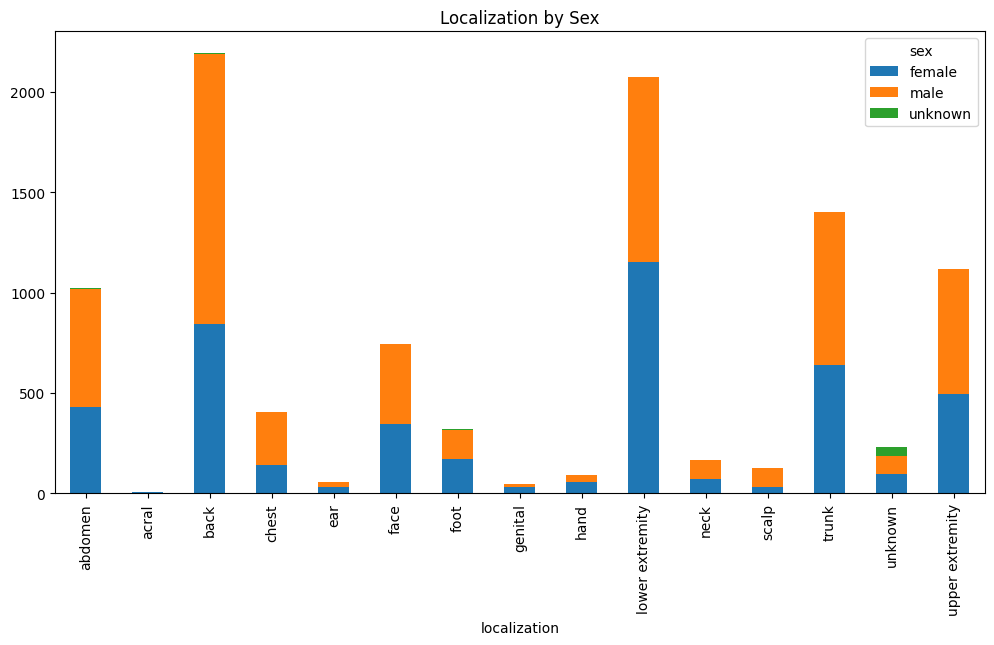

In [12]:
pd.crosstab(skin_df['localization'], skin_df['sex']).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Localization by Sex')
plt.show()


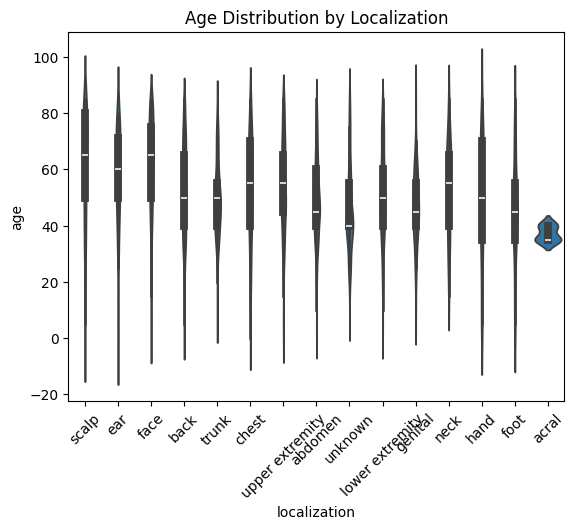

In [13]:
sns.violinplot(x='localization', y='age', data=skin_df)
plt.title('Age Distribution by Localization')
plt.xticks(rotation=45)
plt.show()


In [14]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

<ipython-input-15-bc617a6ef6f9>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


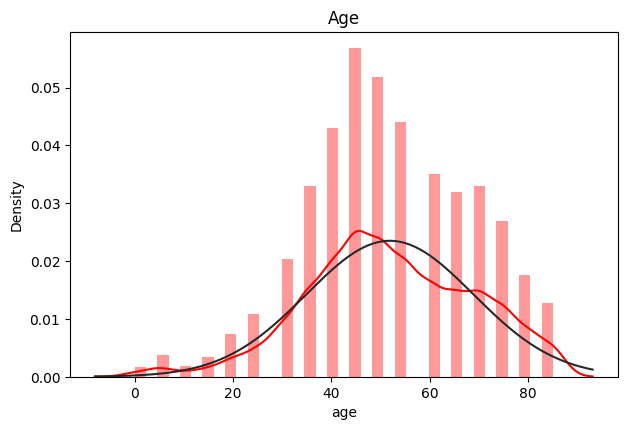

In [15]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [16]:
# Distribution of data into various classes
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [17]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [18]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/HAM1000', '*', '*.jpg'))}

In [19]:
# Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [20]:
# Debugging: Check for missing paths
missing_paths = skin_df_balanced[skin_df_balanced['path'].isnull()]
print(f"Number of missing paths: {len(missing_paths)}")
if not missing_paths.empty:
    print("Sample of missing paths:")
    print(missing_paths[['image_id']].head())

Number of missing paths: 0


In [21]:
# Filter out rows with missing or invalid paths
skin_df_balanced = skin_df_balanced[skin_df_balanced['path'].notnull()]
skin_df_balanced = skin_df_balanced[skin_df_balanced['path'].map(lambda x: os.path.exists(x))]

In [25]:
# Define a safe image loading function
def safe_load_image(path):
    try:
        return np.asarray(Image.open(path).resize((SIZE, SIZE)))
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

In [26]:
# Use the safe function to read images
skin_df_balanced['image'] = skin_df_balanced['path'].map(safe_load_image)

# Drop rows where image loading failed
skin_df_balanced = skin_df_balanced[skin_df_balanced['image'].notnull()]

# Verify results
print(f"Total valid images loaded: {len(skin_df_balanced['image'])}")

Total valid images loaded: 3500


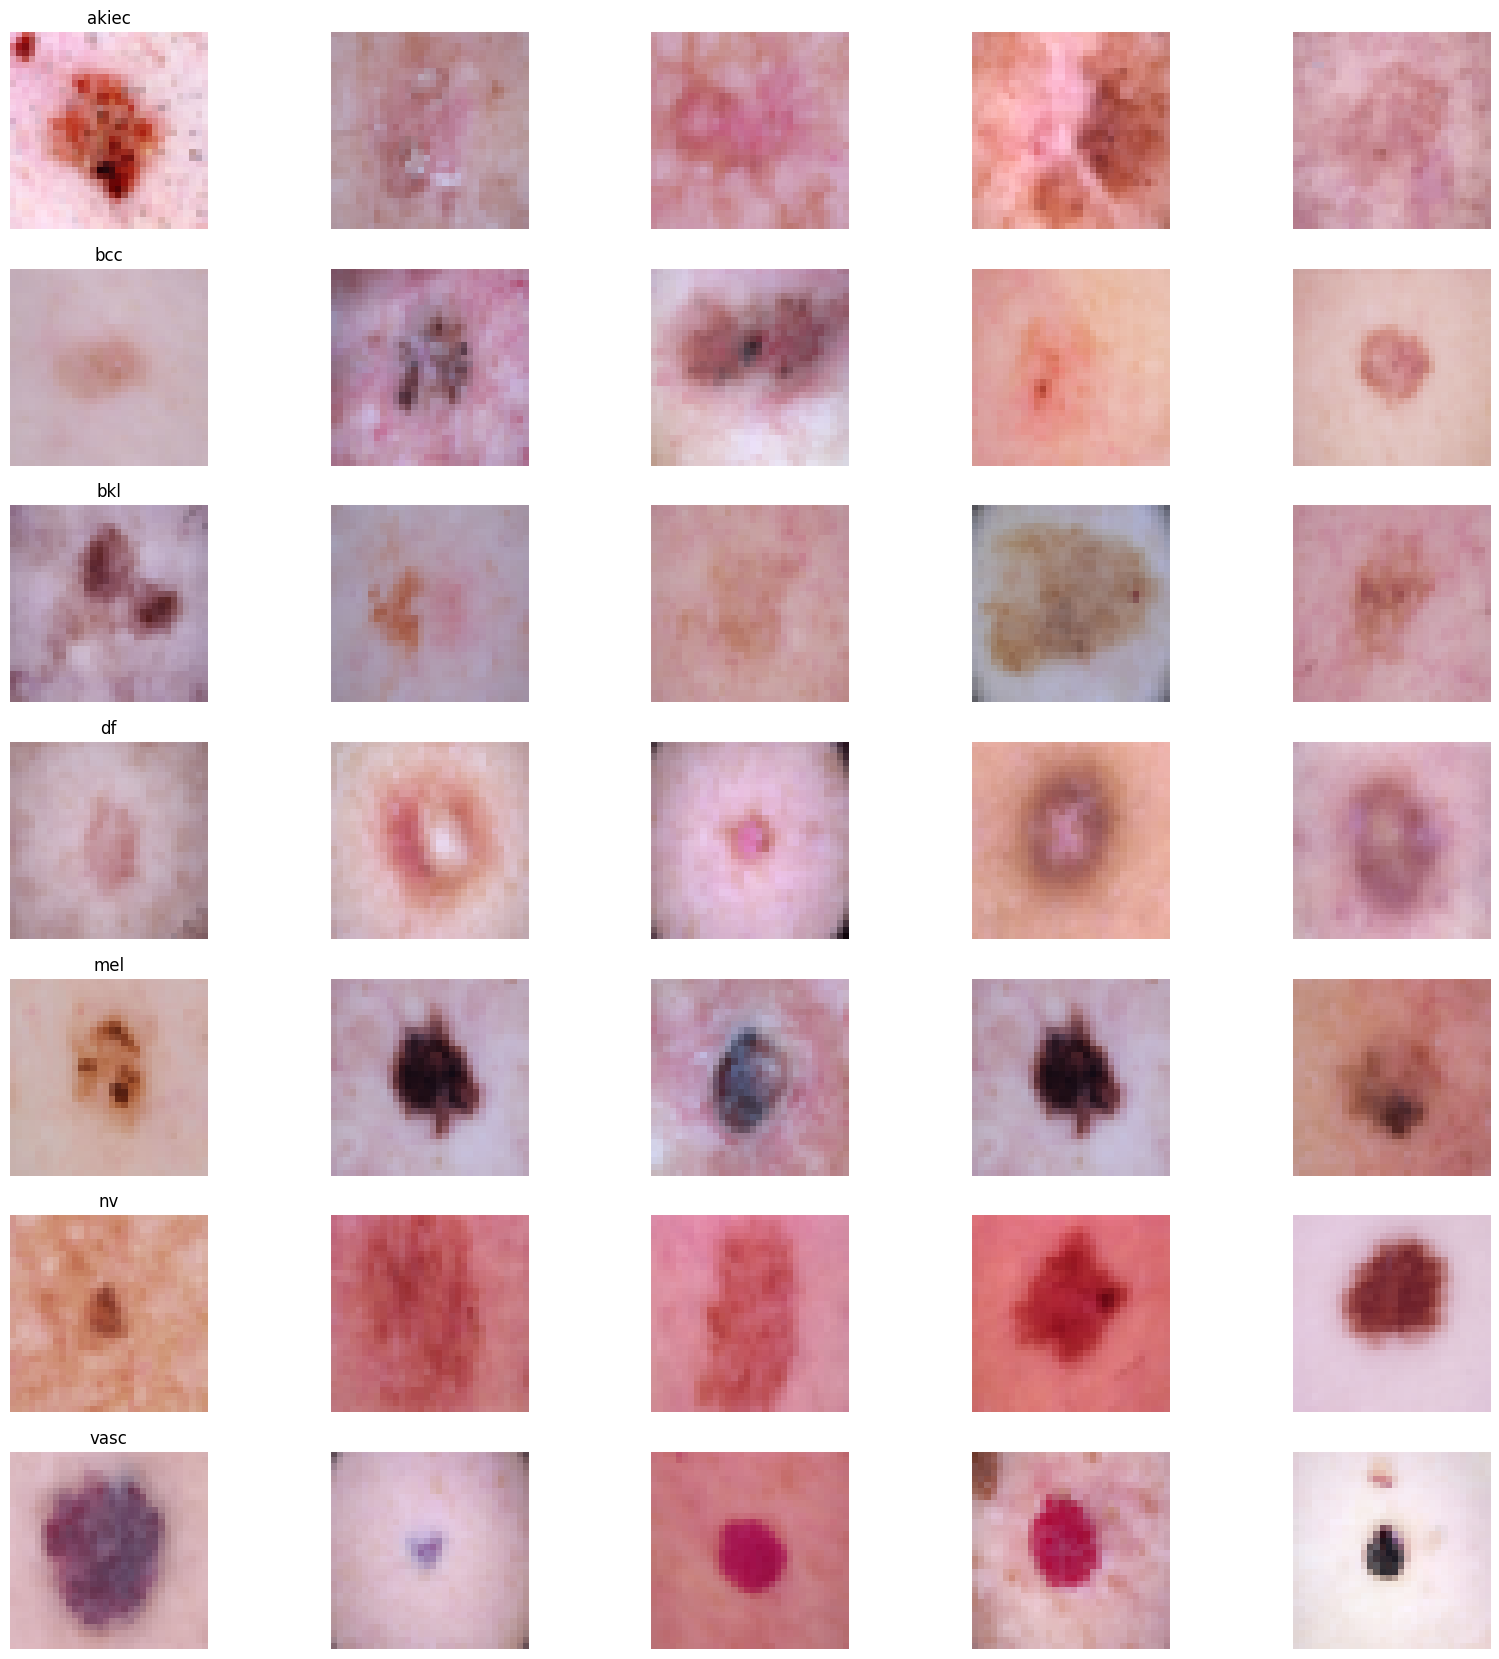

In [27]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


## Visual Inspection of Images
**Random Sample Visualization:**
Plot a grid of random images from each class to observe visual differences in size, shape, texture, and color.

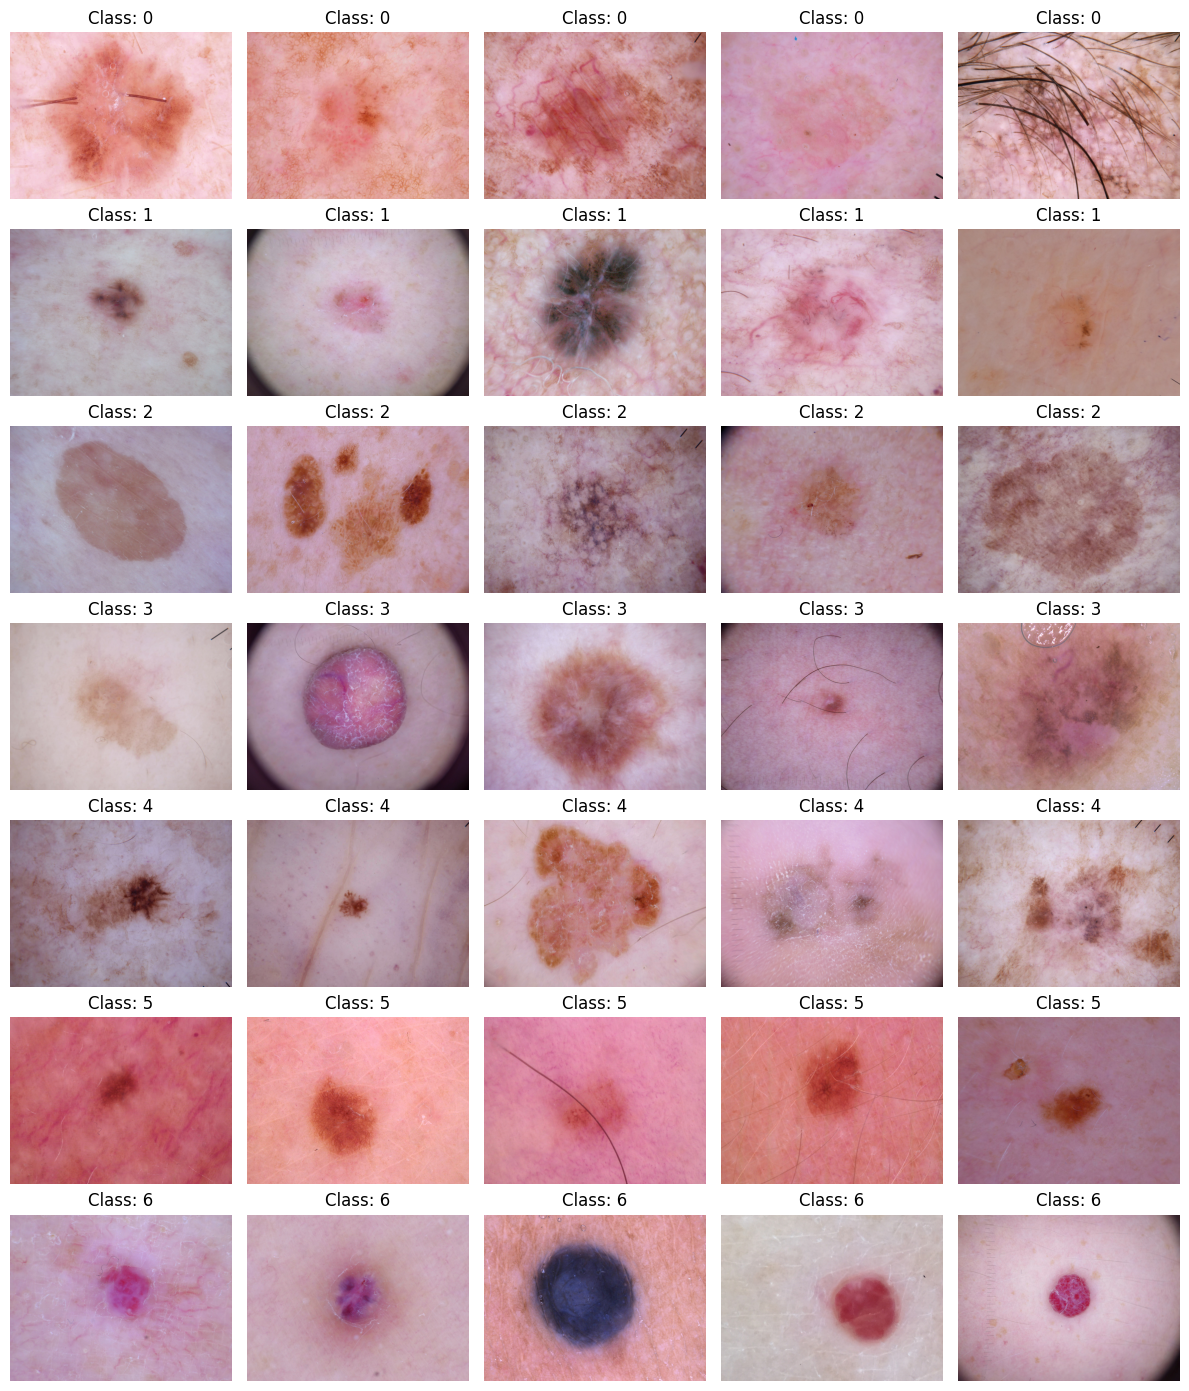

In [28]:
# Function to plot a random sample of images
def plot_sample_images(df, n_samples=5):
    classes = df['label'].unique()
    plt.figure(figsize=(12, len(classes) * 2))
    for i, cls in enumerate(classes):
        sample_images = df[df['label'] == cls].sample(n_samples)
        for j, img_path in enumerate(sample_images['path']):
            plt.subplot(len(classes), n_samples, i * n_samples + j + 1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Class: {cls}")
    plt.tight_layout()
    plt.show()

plot_sample_images(skin_df_balanced)


## Image Property Analysis
Analyze properties such as brightness, contrast, color distribution, and sharpness across the dataset.

**(a) Brightness and Contrast Distribution**

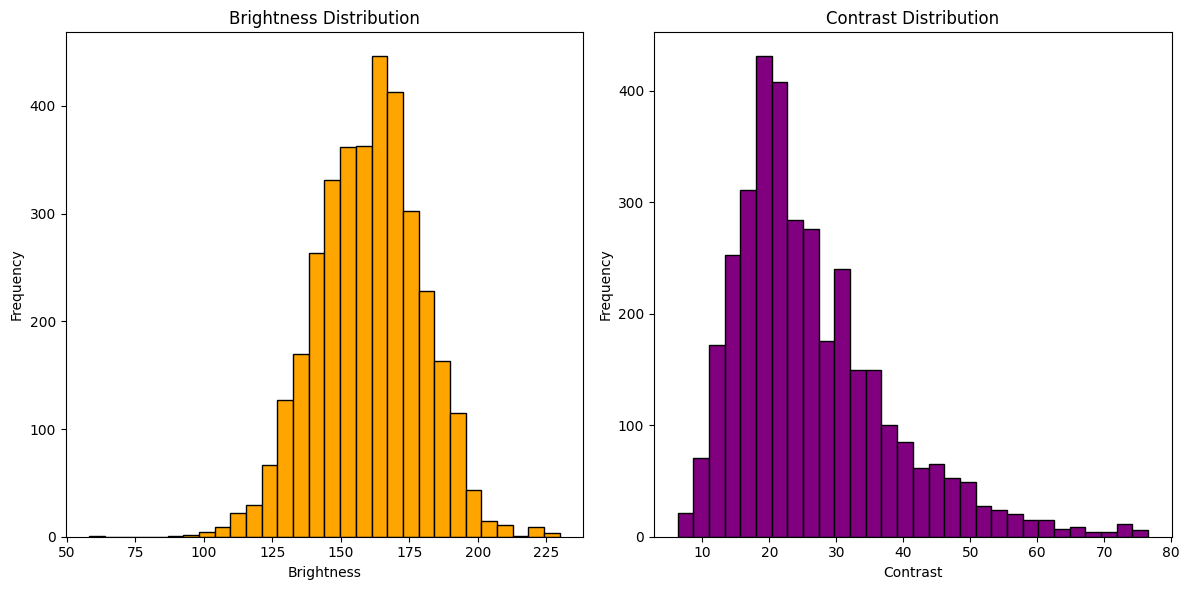

In [29]:
# Compute brightness and contrast
from PIL import ImageStat

brightness = []
contrast = []

for img_path in skin_df_balanced['path']:
    with Image.open(img_path) as img:
        stat = ImageStat.Stat(img.convert("L"))  # Convert to grayscale
        brightness.append(stat.mean[0])  # Average pixel intensity
        contrast.append(stat.stddev[0])  # Pixel intensity standard deviation

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(brightness, bins=30, color='orange', edgecolor='black')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(contrast, bins=30, color='purple', edgecolor='black')
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**(b) Color Analysis**
Analyze the RGB channel distributions to understand color variations:
python



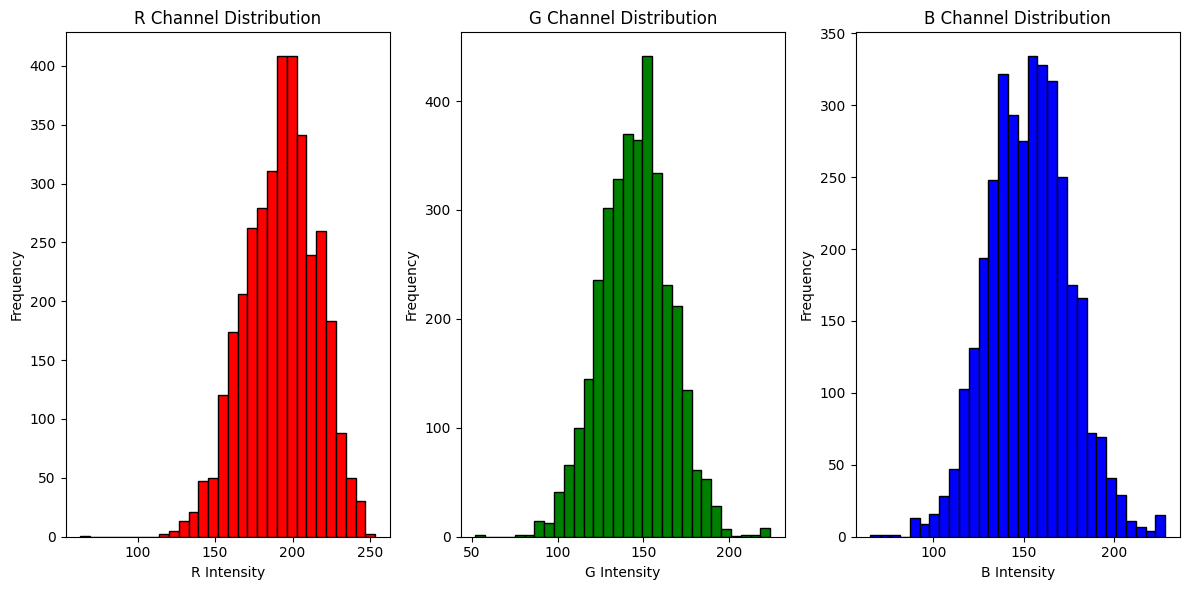

In [30]:
color_means = {'R': [], 'G': [], 'B': []}

for img_path in skin_df_balanced['path']:
    with Image.open(img_path) as img:
        img_array = np.asarray(img)
        color_means['R'].append(np.mean(img_array[:, :, 0]))
        color_means['G'].append(np.mean(img_array[:, :, 1]))
        color_means['B'].append(np.mean(img_array[:, :, 2]))

# Plot color histograms
plt.figure(figsize=(12, 6))

for i, color in enumerate(['R', 'G', 'B']):
    plt.subplot(1, 3, i + 1)
    plt.hist(color_means[color], bins=30, color=color.lower(), edgecolor='black')
    plt.title(f'{color} Channel Distribution')
    plt.xlabel(f'{color} Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Texture Analysis
**Edge Detection: **Use techniques like Canny Edge Detection to analyze texture variations.

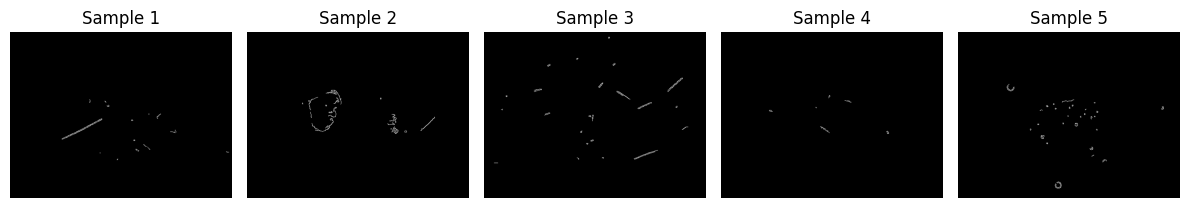

In [31]:
import cv2

def plot_edge_maps(df, n_samples=5):
    plt.figure(figsize=(12, 4))
    for i, img_path in enumerate(df['path'].sample(n_samples)):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(img, 100, 200)  # Apply Canny edge detection
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

plot_edge_maps(skin_df_balanced)


## Spatial Hierarchy and Variation
**Feature Distribution Across Classes:**
Extract features like size, shape, texture, and brightness and compare them across classes to ensure there is inter-class variation.
Example: Compare Average Image Sizes Across Classes
python



In [32]:
size_summary = skin_df_balanced.groupby('label')['path'].apply(
    lambda paths: np.mean([Image.open(path).size for path in paths], axis=0)
)
print(size_summary)


label
0    [600.0, 450.0]
1    [600.0, 450.0]
2    [600.0, 450.0]
3    [600.0, 450.0]
4    [600.0, 450.0]
5    [600.0, 450.0]
6    [600.0, 450.0]
Name: path, dtype: object


**t-SNE Visualization:**
Reduce dimensionality of the pixel data to see if spatial hierarchy or class clusters emerge.

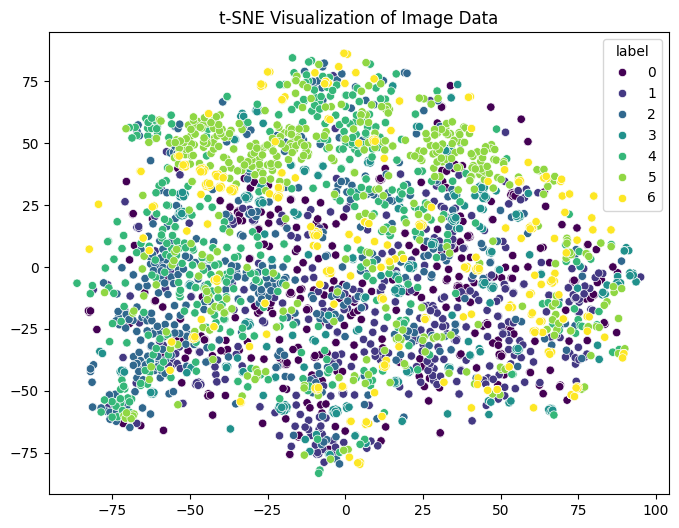

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Flatten image data
img_data = np.stack(skin_df_balanced['image'].values).reshape(len(skin_df_balanced), -1)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(img_data)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=skin_df_balanced['label'], palette='viridis')
plt.title('t-SNE Visualization of Image Data')
plt.show()


In [34]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [35]:
#Define the model.

#We can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Train
#We can also use generator to use augmentation during training.

batch_size = 16
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


Epoch 1/50
165/165 - 35s - 210ms/step - acc: 0.1878 - loss: 1.8970 - val_acc: 0.2720 - val_loss: 1.8156
Epoch 2/50
165/165 - 40s - 245ms/step - acc: 0.2945 - loss: 1.6775 - val_acc: 0.3109 - val_loss: 1.5950
Epoch 3/50
165/165 - 32s - 195ms/step - acc: 0.3627 - loss: 1.5100 - val_acc: 0.3714 - val_loss: 1.4830
Epoch 4/50
165/165 - 41s - 247ms/step - acc: 0.4034 - loss: 1.4463 - val_acc: 0.3566 - val_loss: 1.4818
Epoch 5/50
165/165 - 41s - 248ms/step - acc: 0.4046 - loss: 1.4381 - val_acc: 0.4366 - val_loss: 1.4078
Epoch 6/50
165/165 - 32s - 195ms/step - acc: 0.4408 - loss: 1.3790 - val_acc: 0.3691 - val_loss: 1.4955
Epoch 7/50
165/165 - 42s - 255ms/step - acc: 0.4766 - loss: 1.3393 - val_acc: 0.4400 - val_loss: 1.3265
Epoch 8/50
165/165 - 32s - 193ms/step - acc: 0.4903 - loss: 1.3237 - val_acc: 0.4686 - val_loss: 1.3125
Epoch 9/50
165/165 - 41s - 247ms/step - acc: 0.4933 - loss: 1.2657 - val_acc: 0.4651 - val_loss: 1.2674
Epoch 10/50
165/165 - 41s - 250ms/step - acc: 0.5120 - loss: 1.2

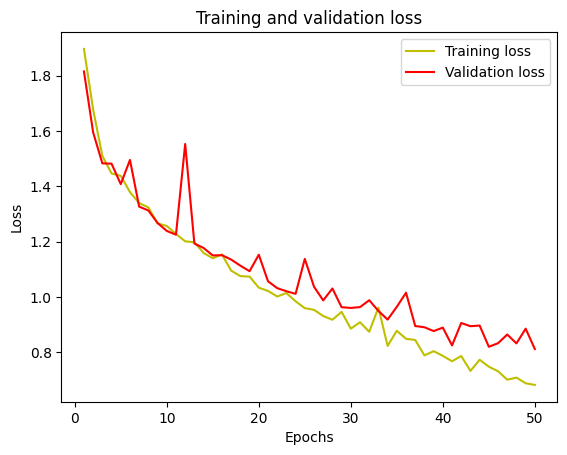

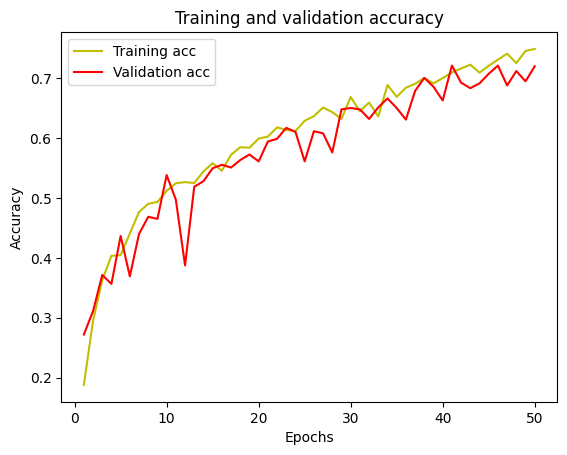

In [37]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


<Axes: >

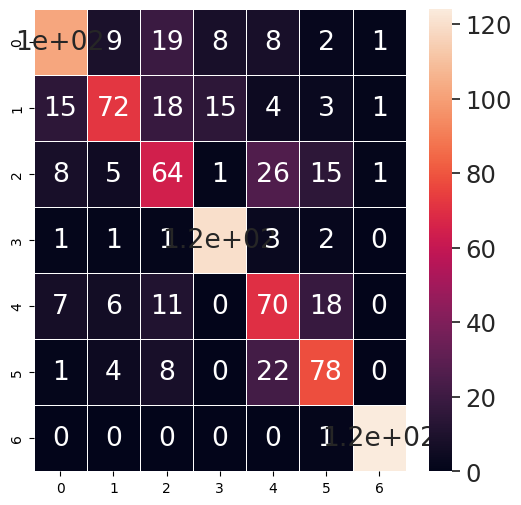

In [38]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


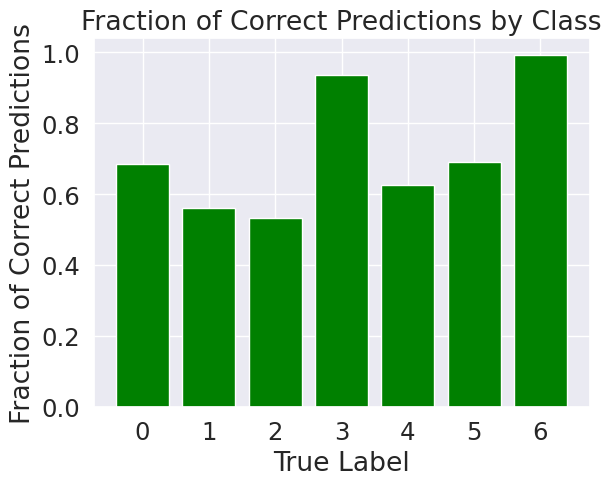

In [40]:
# Calculate the fraction of correct predictions
corr_fraction = np.diag(cm) / np.sum(cm, axis=1)

# Plot correct classification fractions
plt.bar(np.arange(len(corr_fraction)), corr_fraction, color='green')
plt.xlabel('True Label')
plt.ylabel('Fraction of Correct Predictions')
plt.title('Fraction of Correct Predictions by Class')
plt.xticks(np.arange(len(corr_fraction)))  # Optional: set x-ticks for better readability
plt.show()
